In [81]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report

In [82]:
training_data_imputed_df = pd.read_csv("training_data_imputed.csv") 

In [83]:
train_df, val_df = train_test_split(training_data_imputed_df, test_size=0.2, random_state=1)

In [84]:
X = train_df.drop(['cdiff_delta_flag'], axis=1)
y = train_df['cdiff_delta_flag']

print("Class distribution:")
print(y.value_counts())
print(f"Class imbalance ratio: 1:{y.value_counts()[0]/y.value_counts()[1]:.2f}")

Class distribution:
cdiff_delta_flag
0.0    221
1.0     23
Name: count, dtype: int64
Class imbalance ratio: 1:9.61


In [85]:
param_grid = {
    'n_estimators': [25, 50, 100, 200],
    'max_depth': [1, 3, 5, 7, 10],
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
}

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=0
)

scoring = 'roc_auc'

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    cv=skf,
    scoring=scoring,
    verbose=1,
    n_jobs=-1  
)

In [86]:
print("Starting GridSearchCV to find optimal parameters...")
grid_search.fit(X, y)

print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"Best cross-validation {scoring} score: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

Starting GridSearchCV to find optimal parameters...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best parameters found:
{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 50}
Best cross-validation roc_auc score: 0.9648


In [87]:
final_model = xgb.XGBClassifier(**grid_search.best_params_, 
                                objective='binary:logistic',
                                eval_metric='auc',
                                random_state=0)
final_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [88]:
X_final_test = val_df.drop(['cdiff_delta_flag'], axis=1)
y_final_test = val_df['cdiff_delta_flag']

y_final_test.value_counts()

cdiff_delta_flag
0.0    58
1.0     4
Name: count, dtype: int64

In [89]:
y_final_pred = final_model.predict(X_final_test)
y_final_prob = final_model.predict_proba(X_final_test)[:, 1]  

print("\nClassification Report:")
print(classification_report(y_final_test, y_final_pred, target_names=['non-cdiff', 'cdiff']))
print(f"ROC AUC: {roc_auc_score(y_true=y_final_test, y_score=y_final_pred):.4}")


Classification Report:
              precision    recall  f1-score   support

   non-cdiff       0.98      1.00      0.99        58
       cdiff       1.00      0.75      0.86         4

    accuracy                           0.98        62
   macro avg       0.99      0.88      0.92        62
weighted avg       0.98      0.98      0.98        62

ROC AUC: 0.875


<Figure size 1200x800 with 0 Axes>

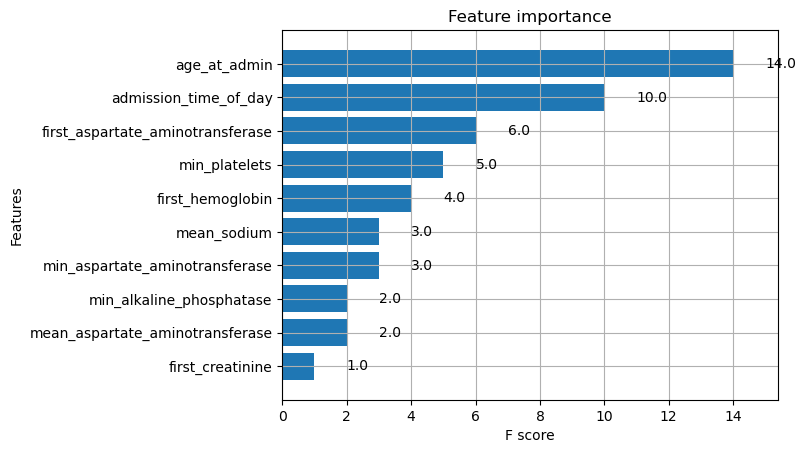

In [90]:
plt.figure(figsize=(12, 8))
xgb.plot_importance(final_model, max_num_features=30, height=0.8)
plt.show()